In [112]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
from models.WienerNet import Wiener, WienerNet
from models.ResUNet import ResUNet
from models.Unrolled_ADMM import Unrolled_ADMM

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [113]:
data_path = '/mnt/WD6TB/tianaoli/dataset/Brain/'
idx = 142

obss, psfs = [], []
for i in range(7):
    for j in range(7):
        psf = torch.load(os.path.join(data_path, 'psf', f"psf_{i*7+j}.pth"))
        psfs.append(psf)
        obs = torch.from_numpy(np.load(os.path.join(data_path, 'obs', f"obs_{idx*49+7*i+j}.npy"))).float()
        obss.append(obs)

IP_img = np.load(os.path.join(data_path, 'sections', f'{idx}.npy')) 
gt_full = np.load(os.path.join(data_path, 'full_image', 'gt', f"gt_full_{idx}.npy")) 
obs_full = np.load(os.path.join(data_path, 'full_image', 'obs', f"obs_full_{idx}.npy")) 

### Deconvolve with WienerNet

In [114]:
ncs = [32, 16, 8]
rec_fulls = []
pretrained_epochs = [118, 156, 170] # MultiScale
loss = 'MultiScale' # 'MSE'
for nc, pretrained_epoch in zip(ncs, pretrained_epochs):
    model = WienerNet(nc=[nc, nc*2, nc*4, nc*8])
    model.to(device)
    pretrained_file = os.path.join('../saved_models_Brain/', f'WienerNet_{nc}channels_{loss}_{pretrained_epoch}epochs.pth')
    model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {pretrained_file}.')
    model.eval()
    
    rec_full, weights = np.zeros_like(gt_full), np.zeros_like(gt_full)
    for i in range(7):
        for j in range(7):
            obs, psf = obss[i*7+j], psfs[i*7+j]
            mean = obs.abs().mean()
            obs, psf = obs.unsqueeze(0).to(device), psf.to(device)
            with torch.no_grad():
                rec = model(obs/mean, psf) * mean
            rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
            rec_full[32*i:32*i+64, 32*j:32*j+64] += rec
            weights[32*i:32*i+64, 32*j:32*j+64] += 1
    rec_fulls.append(rec_full/weights)

Successfully loaded in ../saved_models_Brain/WienerNet_32channels_MultiScale_118epochs.pth.
Successfully loaded in ../saved_models_Brain/WienerNet_16channels_MultiScale_156epochs.pth.
Successfully loaded in ../saved_models_Brain/WienerNet_8channels_MultiScale_170epochs.pth.


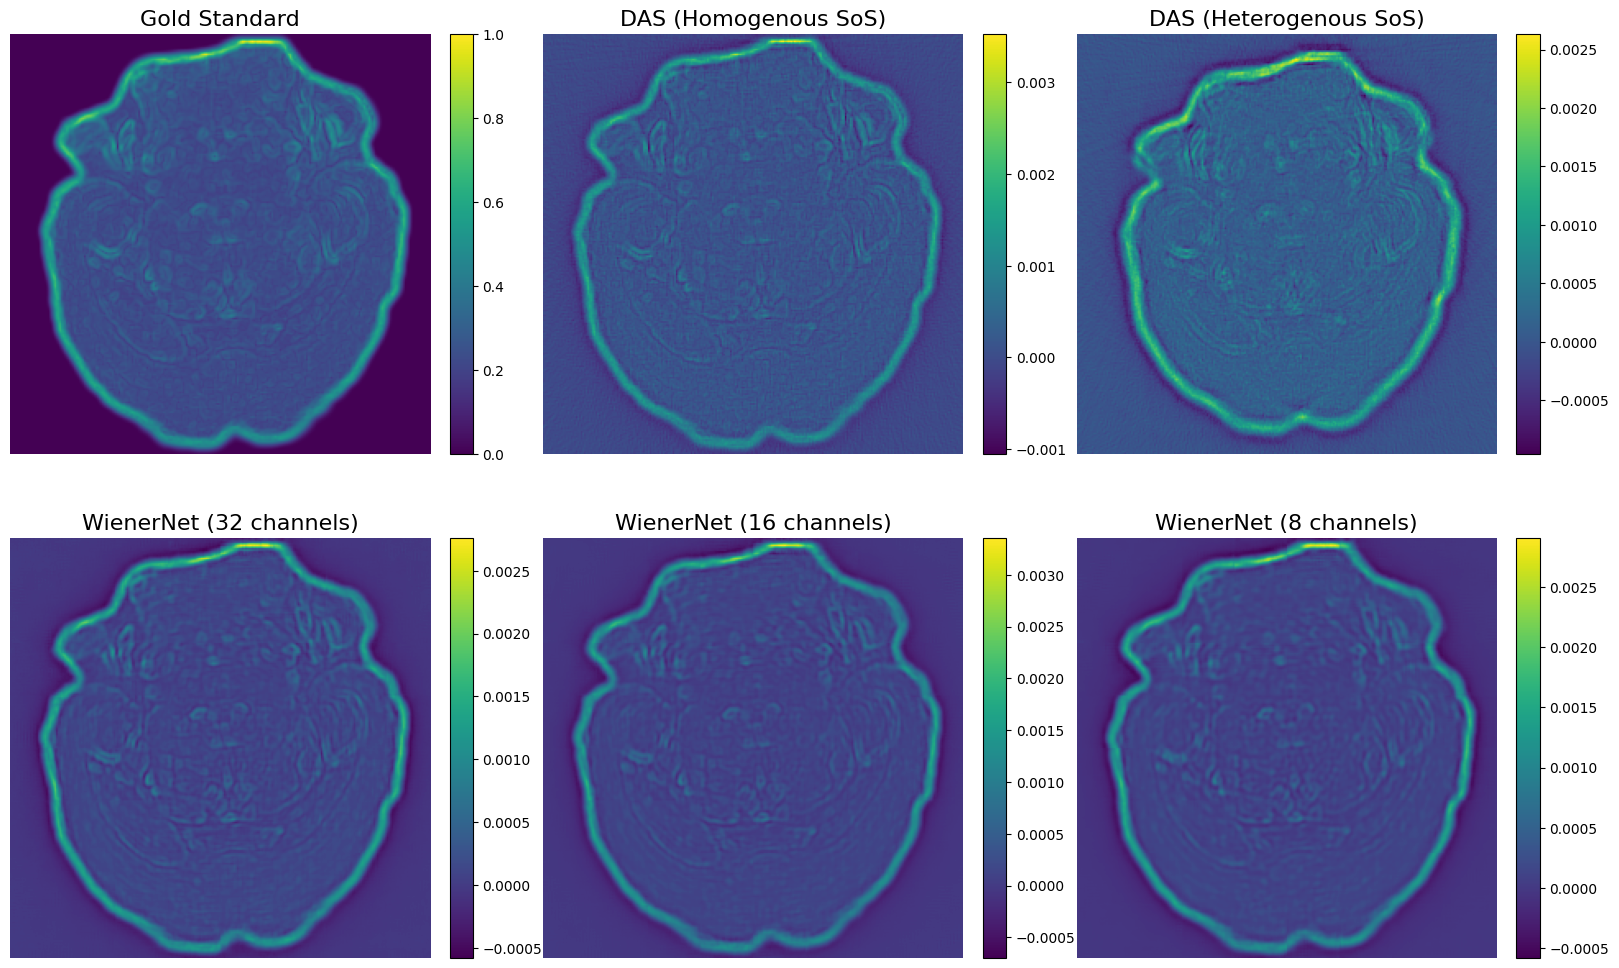

In [116]:
fig = plt.figure(figsize=(19.5, 12))
ax1 = plt.subplot(2,3,1)
plt.imshow(IP_img)
plt.title('Gold Standard', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.012, ax1.get_position().height])
cb = plt.colorbar(cax=cax)

ax2 = plt.subplot(2,3,2)
plt.imshow(gt_full)
plt.title('DAS (Homogenous SoS)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.012, ax2.get_position().height])
cb = plt.colorbar(cax=cax)

ax3 = plt.subplot(2,3,3)
plt.imshow(obs_full[3])
plt.title('DAS (Heterogenous SoS)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax3.get_position().x1+0.01, ax3.get_position().y0, 0.012, ax3.get_position().height])
cb = plt.colorbar(cax=cax)

ax4 = plt.subplot(2,3,4)
plt.imshow(rec_fulls[0])
plt.title(f'WienerNet ({ncs[0]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax4.get_position().x1+0.01, ax4.get_position().y0, 0.012, ax4.get_position().height])
cb = plt.colorbar(cax=cax)

ax5 = plt.subplot(2,3,5)
plt.imshow(rec_fulls[1])
plt.title(f'WienerNet ({ncs[1]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax5.get_position().x1+0.01, ax5.get_position().y0, 0.012, ax5.get_position().height])
cb = plt.colorbar(cax=cax)

ax6 = plt.subplot(2,3,6)
plt.imshow(rec_fulls[2])
plt.title(f'WienerNet ({ncs[2]} channels)', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax6.get_position().x1+0.01, ax6.get_position().y0, 0.012, ax6.get_position().height])
cb = plt.colorbar(cax=cax)

# plt.tight_layout()